In [2]:
import pandas as pd
import numpy as np
import requests
import json
import time
import os 

from scripts.vectology_functions import create_aaa_distances, create_pair_distances, embed_text, encode_traits
from nxontology import NXOntology

from ontoma import OnToma
otmap = OnToma()

import seaborn as sns

# Apply the default theme
sns.set_theme()

INFO     - ontoma.downloaders - ZOOMA to EFO mappings - Parsed 3663 rows
INFO     - ontoma.downloaders - OMIM to EFO mappings - Parsed 8561 rows


In [3]:
# files
ebi_data = 'data/UK_Biobank_master_file.tsv'
#efo_nodes = 'data/efo-nodes.tsv'
efo_data = 'data/efo_data.txt.gz'

In [4]:
# get the EBI UKB data
#get ebi data
#url='https://raw.githubusercontent.com/EBISPOT/EFO-UKB-mappings/master/UK_Biobank_master_file.tsv'
#ebi_df = pd.read_csv(url,sep='\t')

ebi_df = pd.read_csv(ebi_data,sep='\t')

#drop some columns
ebi_df = ebi_df[['ZOOMA QUERY','MAPPED_TERM_LABEL','MAPPED_TERM_URI']]
ebi_df.rename(columns={'ZOOMA QUERY':'query'},inplace=True)
print(ebi_df.head())
print(ebi_df.shape)

#create new rows for multiple labels
#ebi_df = (
#        ebi_df.assign(label=ebi_df.MAPPED_TERM_LABEL.str.split("\|\|"))
#        .explode("label")
#        .reset_index(drop=True).drop('MAPPED_TERM_LABEL',axis=1)
#    )

#create new rows for multiple ids
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|\|',',')
ebi_df['MAPPED_TERM_URI']=ebi_df['MAPPED_TERM_URI'].str.replace('\|',',')
ebi_df = (
        ebi_df.assign(id=ebi_df.MAPPED_TERM_URI.str.split(","))
        .explode("id")
        .reset_index(drop=True).drop('MAPPED_TERM_URI',axis=1)
    )

#clean up
ebi_df['id'] = ebi_df['id'].str.strip()

#drop cases where query and id are the same
ebi_df.drop_duplicates(subset=['query','id'],inplace=True)
print(ebi_df.shape)

#drop nan
ebi_df.dropna(inplace=True)
print(ebi_df.shape)
print(ebi_df.head())


                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            MAPPED_TERM_URI  
0  EFO_0004264, EFO_0009431  
1               EFO_0004616  
2               EFO_0003778  
3               EFO_0003901  
4               EFO_0004247  
(1565, 3)
(1613, 3)
(1600, 3)
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4       

In [5]:
%%time

# get EFO node data
#efo_df=pd.read_csv(efo_nodes,sep='\t',names=['name','label','type'])
#print(efo_df.head())
#print(efo_df.shape)

# EFO data
efo_df = pd.read_json(efo_data)
#print(efo_df.head())
node_data = []
for i,rows in efo_df.iterrows():
    node_data.append({
        'id':rows['child']['value'],
        'name':rows['childLabel']['value'],
    })
    node_data.append({
        'id':rows['parent']['value'],
        'name':rows['parentLabel']['value'],
        
    })
efo_node_df = pd.DataFrame(node_data)
efo_node_df.drop_duplicates(inplace=True)
print(efo_node_df)

                                              id  \
0           http://www.ebi.ac.uk/efo/EFO_0004285   
1      http://purl.obolibrary.org/obo/HP_0000093   
2           http://www.ebi.ac.uk/efo/EFO_0004207   
3      http://purl.obolibrary.org/obo/HP_0000545   
4           http://www.ebi.ac.uk/efo/EFO_0002608   
...                                          ...   
53112  http://purl.obolibrary.org/obo/HP_0002840   
53114  http://purl.obolibrary.org/obo/PO_0030015   
53118  http://purl.obolibrary.org/obo/EO_0007068   
53120  http://purl.obolibrary.org/obo/HP_0002313   
53124   http://purl.obolibrary.org/obo/FMA_24984   

                                      name  
0                              albuminuria  
1                              Proteinuria  
2                      pathological myopia  
3                                   Myopia  
4                            AIDS dementia  
...                                    ...  
53112                        lymphadenitis  
53114  sporophy

In [6]:
#check all terms in EBI data set are in EFO node data
efo_node_ids = list(efo_node_df['id'])
ebi_ids = list(ebi_df['id'])
missing=[]
matched = []
for i in ebi_ids:
    match = False
    for s in efo_node_ids:
        if i in s and match == False:
            matched.append(s)
            match = True
    if match == False:
        missing.append(i)
print('Missing:',len(missing),missing)

# remove missing from ukb data
print(ebi_df.shape)
for i in missing:
    ebi_df = ebi_df.drop(ebi_df[ebi_df['id'].str.contains(i)].index)
ebi_df['full_id'] = matched
print(ebi_df.head())
print(ebi_df.shape)
ebi_df.to_csv('output/ebi-ukb-cleaned.tsv',index=False,sep='\t')


Missing: 517 ['EFO_0009431', 'EFO_0009386', 'EFO_0009314', 'EFO_0009431', 'EFO_0009387', 'EFO_0009607', 'EFO_0009431', 'EFO_0009432', 'EFO_0009433', 'EFO_0009434', 'Orphanet_363189', 'Orphanet_98724', 'EFO_1002050', 'EFO_0009449', 'EFO_0009450', 'EFO_0009451', 'EFO_0009452', 'EFO_0009453', 'EFO_0009454', 'EFO_0009455', 'EFO_0009456', 'EFO_1002046', 'EFO_1002047', 'EFO_1002050', 'EFO_1002051', 'HP_0000008', 'HP_0000008', 'HP_0000022', 'HP_0000022', 'HP_0000517', 'HP_0000614', 'HP_0000751', 'HP_0000769', 'HP_0000952', 'HP_0001094', 'HP_0001288', 'HP_0001325', 'HP_0001399', 'HP_0001537', 'HP_0001561', 'EFO_0009492', 'HP_0001760', 'HP_0001787', 'HP_0001787', 'HP_0001787', 'HP_0001877', 'HP_0001881', 'HP_0002045', 'HP_0002716', 'HP_0002921', 'HP_0003076', 'HP_0004329', 'HP_0004338', 'HP_0004367', 'HP_0004371', 'HP_0001671', 'HP_0005224', 'HP_0005957', 'EFO_0009493', 'HP_0007700', 'HP_0010313', 'HP_0010771', 'HP_0010944', 'HP_0000069', 'HP_0011411', 'HP_0012075', 'HP_0012075', 'HP_0012410', 

In [189]:
# preprocess
process_text=[]
for k,g in ebi_df.groupby(np.arange(len(ebi_df))//20):
    params={'text_list':list(g['query'])}
    process_res = requests.post('http://vectology-api.mrcieu.ac.uk/preprocess',data=json.dumps(params))
    process_text.extend([d['result'].replace('unspecified','').replace('nec','') for d in process_res.json()])
print(len(process_text))
    
ebi_df.loc[:, 'processed'] = process_text
print(ebi_df.head())

1083
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
2                              Gonarthrosis  osteoarthritis || knee   
3  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
4          Pain associated with micturition                 dysuria   
5                                Other mood           mood disorder   

            id                                 processed  \
0  EFO_0004264           vascular disorders of intestine   
2  EFO_0004616                              gonarthrosis   
3  EFO_0003778  psoriatic and enteropathic arthropathies   
4  EFO_0003901          pain associated with micturition   
5  EFO_0004247                                other mood   

                                          BioSentVec  \
0  [0.014145898632705212, 0.4755328297615051, -0....   
2  [0.15413393080234528, -1.4173569679260254, -0....   
3  [0.4655860960483551, 0.2004084885120

In [7]:
%%time

f='output/ebi-ukb-vec.tsv.gz'
if os.path.exists(f):
    print('Already done')
    ebi_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    ebi_df['BioSentVec'] = ebi_df['BioSentVec'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    ebi_df = encode_traits(trait_df=ebi_df,col='processed',name='BioSentVec',model='BioSentVec')
    ebi_df.to_csv(f,sep='\t',compression='gzip',index=False)
print(ebi_df.head())
print(ebi_df.shape)

Already done
                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            id                                 processed  \
0  EFO_0004264           vascular disorders of intestine   
1  EFO_0004616                              gonarthrosis   
2  EFO_0003778  psoriatic and enteropathic arthropathies   
3  EFO_0003901          pain associated with micturition   
4  EFO_0004247                                other mood   

                                          BioSentVec  \
0  [0.014145898632705212, 0.4755328297615051, -0....   
1  [0.15413393080234528, -1.4173569679260254, -0....   
2  [0.4655860960483551, 0.20040

In [8]:
%%time

f='output/efo-vec.tsv.gz'
if os.path.exists(f):
    print('Already done')
    efo_df = pd.read_csv(f,sep='\t')
    #issues with reading vectors from CSV 
    efo_df['BioSentVec'] = efo_df['BioSentVec'].apply(lambda x: [float(y) for y in x.replace('[','').replace(']','').split(',')])
else:
    efo_df = encode_traits(trait_df=efo_node_df,col='name',name='BioSentVec',model='BioSentVec')
    efo_df.to_csv(f,sep='\t',compression='gzip',index=False)
    
print(efo_df.head())


Already done
                                          id                 name  \
0       http://www.ebi.ac.uk/efo/EFO_0004285          albuminuria   
1  http://purl.obolibrary.org/obo/HP_0000093          Proteinuria   
2       http://www.ebi.ac.uk/efo/EFO_0004207  pathological myopia   
3  http://purl.obolibrary.org/obo/HP_0000545               Myopia   
4       http://www.ebi.ac.uk/efo/EFO_0002608        AIDS dementia   

                                          BioSentVec  
0  [0.4202117919921875, -0.17832736670970917, -1....  
1  [0.4231119751930237, -0.4265417158603668, -0.9...  
2  [0.39966529607772827, -0.34570133686065674, -0...  
3  [0.5090897083282471, -0.6281495094299316, -1.8...  
4  [0.9064940214157104, 0.29144150018692017, 0.15...  
CPU times: user 11.5 s, sys: 592 ms, total: 12 s
Wall time: 12.2 s


In [10]:
#create nxontology network of EFO relationships
def create_efo_nxo() -> NXOntology:
    nxo = NXOntology()
    
    edges = []
    efo_rel_df=pd.read_json(efo_data)
    for i,row in efo_rel_df.iterrows():
        child = row['child']['value']
        parent = row['parent']['value']
        edges.append((parent,child))
    #print(edges[0:10])
    nxo.graph.add_edges_from(edges)
    return nxo

efo_nx = create_efo_nxo()
efo_nx.freeze()

In [11]:
%%time

#ebi_df['BioSentVec']
v1 = list(ebi_df['BioSentVec'])

v2 = list(efo_df['BioSentVec'])


CPU times: user 2.76 ms, sys: 20 µs, total: 2.78 ms
Wall time: 2.85 ms


In [12]:
%%time
# cosine of all against all
dd = create_pair_distances(v1,v2)

Creating distances...
1083 21865
1083
CPU times: user 16.3 s, sys: 203 ms, total: 16.5 s
Wall time: 16.6 s


                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            id                                 processed  \
0  EFO_0004264           vascular disorders of intestine   
1  EFO_0004616                              gonarthrosis   
2  EFO_0003778  psoriatic and enteropathic arthropathies   
3  EFO_0003901          pain associated with micturition   
4  EFO_0004247                                other mood   

                                          BioSentVec  \
0  [0.014145898632705212, 0.4755328297615051, -0....   
1  [0.15413393080234528, -1.4173569679260254, -0....   
2  [0.4655860960483551, 0.20040848851203918,

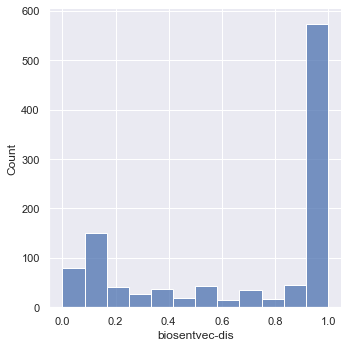

In [13]:
count=0
dis_results=[]
for i,irows in ebi_df.iterrows():
    #print('\nEBI:',count,irows[['query','MAPPED_TERM_LABEL','full_id']].values)
    try:
        min_dis = np.nanargmin(dd[count])
        min_val = np.nanmin(dd[count])
    except:
        min_dis=0
    #print('EFO:',efo_df.iloc[min_dis][['name','id']].values,min_val)
    try:
        res = similarity = efo_nx.similarity(irows['full_id'],efo_df.iloc[min_dis]['id']).results()
        #print(res['batet'])
        dis_results.append(res['batet'])
    except:
        print('something wrong')
        exit()
    count+=1
ebi_df['biosentvec-dis']=dis_results
print(ebi_df.head())

#plot
sns.displot(ebi_df, x="biosentvec-dis")

In [7]:
# ontoma 
print(otmap.find_term('Vascular disorders of intestine'))
#think this is just using zooma

INFO     - ontoma.interface - HP OBO parsed. Size: 15512 nodes
INFO     - ontoma.interface - Parsed 34471 Name to HP mapping 
WARNING  - ontoma.interface - Found http://purl.obolibrary.org/obo/MONDO_0003159 for Vascular disorders of intestine from OLS API EFO lookup - fuzzy - check if valid


http://purl.obolibrary.org/obo/MONDO_0003159


In [40]:
# zooma using web app
# ran the web app using filtered list of terms
# Configure Data Sources - Don't search in any datasources checked
# Configure Ontology Sources - EFO
# https://www.ebi.ac.uk/spot/zooma
zooma_df = pd.read_csv('data/zooma.tsv',sep='\t')
zooma_df['zooma_efo'] = zooma_df['ONTOLOGY(S)']+zooma_df['ONTOLOGY TERM(S)']
zooma_df.drop_duplicates(subset=['zooma_efo'],inplace=True)
print(zooma_df.shape)

(929, 10)


In [14]:
# zooma using API
def run_zooma(text):
    zooma_api = 'https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate'
    payload = {
        'propertyValue':text,
        'filter':'required:[none],ontologies:[efo]'
    }
    res = requests.get(zooma_api,params=payload).json()
    if res:
        #print(text,res[0]['semanticTags'])
        return res[0]['semanticTags'][0]
    else:
        return 'NA'

In [15]:
%%time

# takes around 3 minutes for 1,000

ebi_df['zooma_api'] = ebi_df['query'].apply(lambda x:run_zooma(x))
ebi_df.to_csv('output/ebi-zooma-api.tsv',sep='\t',index=False)
print(ebi_df.head())

                                      query       MAPPED_TERM_LABEL  \
0           Vascular disorders of intestine        vascular disease   
1                              Gonarthrosis  osteoarthritis || knee   
2  Psoriatic and enteropathic arthropathies     psoriatic arthritis   
3          Pain associated with micturition                 dysuria   
4                                Other mood           mood disorder   

            id                                 processed  \
0  EFO_0004264           vascular disorders of intestine   
1  EFO_0004616                              gonarthrosis   
2  EFO_0003778  psoriatic and enteropathic arthropathies   
3  EFO_0003901          pain associated with micturition   
4  EFO_0004247                                other mood   

                                          BioSentVec  \
0  [0.014145898632705212, 0.4755328297615051, -0....   
1  [0.15413393080234528, -1.4173569679260254, -0....   
2  [0.4655860960483551, 0.20040848851203918,

1083


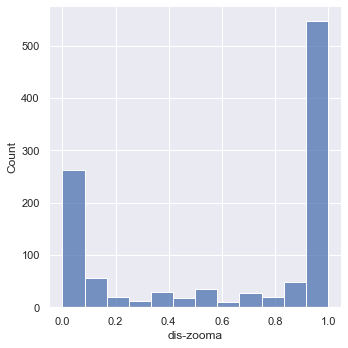

In [16]:
#print(zooma_df.head())

# merge with ebi file
#m = pd.merge(zooma_df,ebi_df,left_on='PROPERTY VALUE',right_on='query')
#m.drop_duplicates(inplace=True)
#print(m.head())
#print(m.shape)

dis_results=[]
for i, row in ebi_df.iterrows():
    try:
        res = similarity = efo_nx.similarity(row['zooma_api'],row['full_id']).results()
        #print(res['batet'])
        dis_results.append(res['batet'])
    except:
        dis_results.append(0)
print(len(dis_results))
ebi_df['dis-zooma']=dis_results
sns.displot(ebi_df, x="dis-zooma")